<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_02_28_jax_three_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Neural Net in Jax

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/GNLOa4riys8).

## Acknowledgment:
I borrowed some code from [UvA Deep Learning Tutorials](https://github.com/phlippe/uvadlc_notebooks/tree/master) and [Jax Advanced Tutorials](https://jax.readthedocs.io/en/latest/advanced_guide.html).

## References:
```bibtex
@software{jax2018github,
 author  = {James Bradbury and Roy Frostig and Peter Hawkins and Matthew James Johnson and Chris Leary and Dougal Maclaurin and George Necula and Adam Paszke and Jake Vander{P}las and Skye Wanderman-{M}ilne and Qiao Zhang},
 title  = {{JAX}: composable transformations of {P}ython+{N}um{P}y programs},
 url    = {http://github.com/google/jax},
 version = {0.3.13},
 year   = {2018},
}
```
```bibtex
@misc{lippe2022uvadlc,
   title        = {{UvA Deep Learning Tutorials}},
   author       = {Phillip Lippe},
   year         = 2022,
   howpublished = {\url{https://uvadlc-notebooks.readthedocs.io/en/latest/}}
}
```

## Import libraries

In [ ]:
# Standard libraries
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from torch.utils import data

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# jax
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map
import flax
from flax import linen as nn
from flax.training import train_state
import optax

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.model_selection import train_test_split

In [ ]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
batch_size = 32

## Toy Dataset
Here we create a two dimensional toy dataset using `data.Dataset` class. Creating a `Dataset` instance will help us creating a `Dataloader` for training and testing.

In [ ]:
class ToyDataset(data.Dataset):

  def __init__(self, size, seed):
    super().__init__()
    self.size = size
    self.np_rng = np.random.RandomState(seed=seed)
    self.make_nested_classes()

  def make_nested_classes(self):
    X, y = make_blobs(n_samples=int(self.size*0.2), n_features=2, centers=2, cluster_std=1.9, random_state=random_seed)
    X1, y1 = make_circles(n_samples=(int(self.size*0.6), int(self.size*0.2)), noise=0.05, factor=0.1, random_state=random_seed)
    # increase the radius
    X1 = X1*3
    # move along the x-axis
    X1[:,0] = X1[:,0]+2.5
    # move along the y-axis
    X1[:,1] = X1[:,1]-7

    X = np.concatenate((X, X1), axis=0)
    y = np.concatenate((y, y1), axis=0)

    self.data = X
    self.label = y

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [ ]:
dataset = ToyDataset(size=1000, seed=random_seed)
dataset

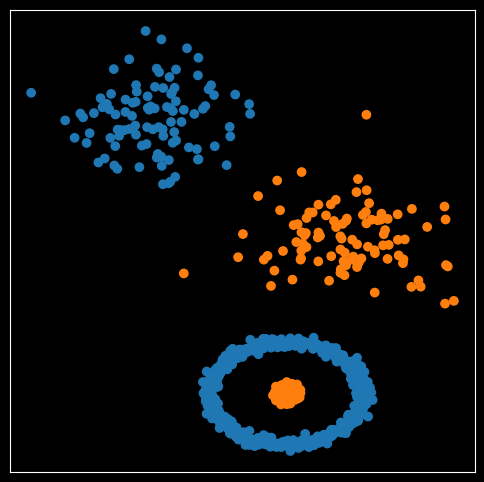

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dataset.data[:,0], dataset.data[:,1], marker='o', color=np.array(plot_colors)[dataset.label])

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()

## Train/Test splits
We split the dataset to 80% for training and 20% for testing using `data.random_split`. Then we package these splits in dataloaders. We specified `collate_fn=numpy_collate` to create numpy batches instead of torch tensor batches, which is the default option.

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

In [ ]:
def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)

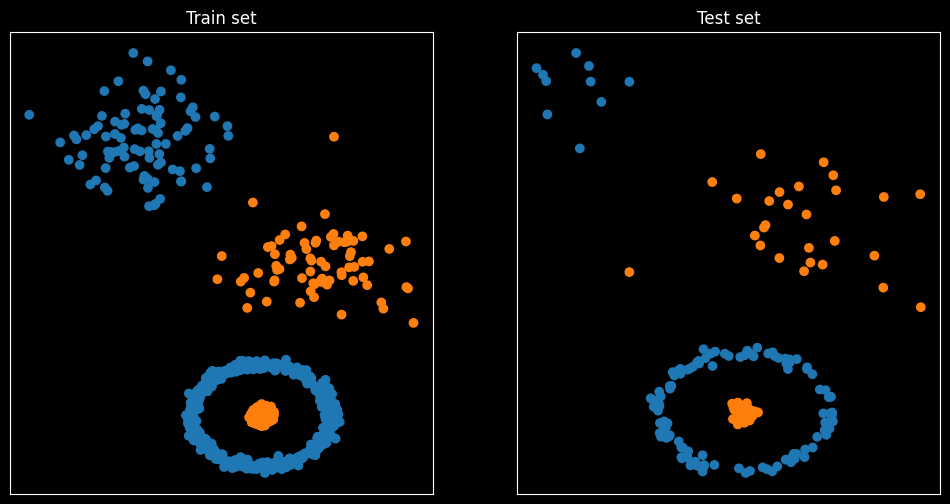

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Train set')
for sample, label in train_data_loader:
  axs[0].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

axs[1].set_title('Test set')
for sample, label in test_data_loader:
  axs[1].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

for ax in axs:
  ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax.set(xlabel=None, ylabel=None)
plt.show()

## Simple Neural Net Architecture

### A visualization of the network we're trying to build

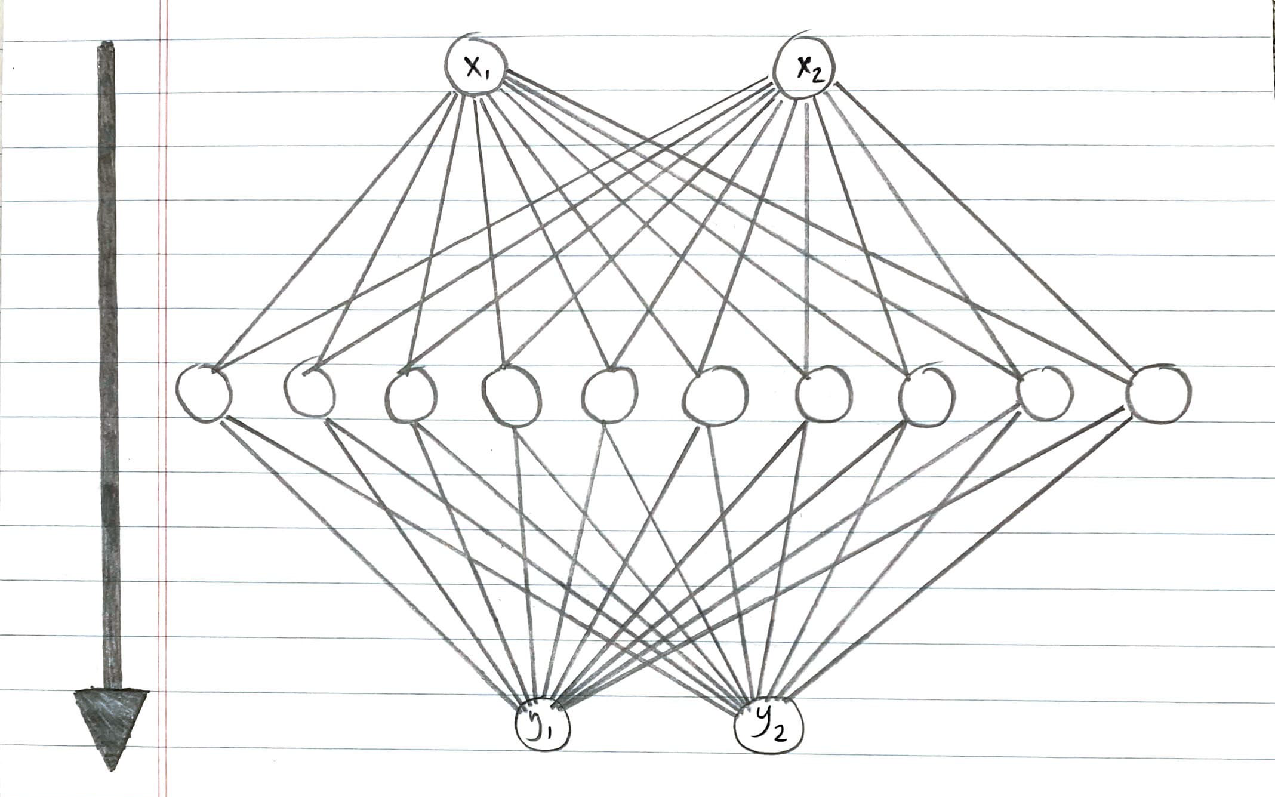

### An even better visualization of the network we're trying to build

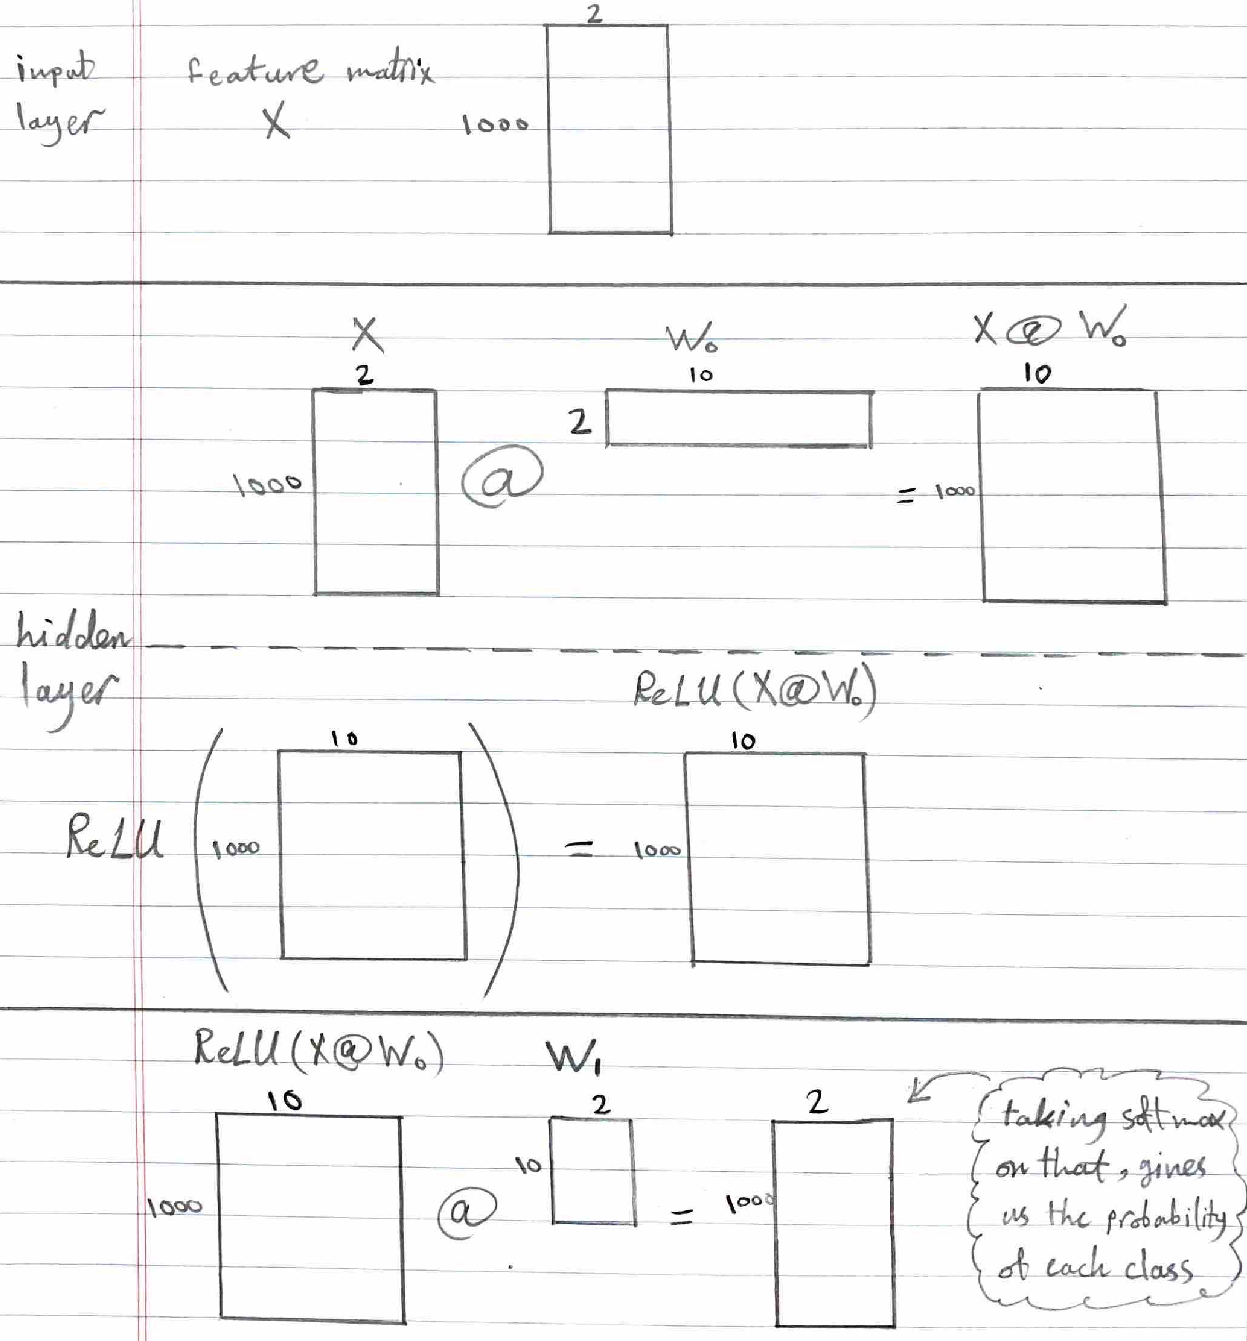

The `MLPClassifier` creates a neural net instance where the hidden layers are specified by the user. It applies `relu` function to the hidden layer output and applies `log_softmax` to the output. We initialize the `MLPClassifier` to one hidden layer with ten neurons.

In [ ]:
class MLPClassifier(nn.Module):
    hidden_layers: int
    hidden_dim: int
    n_classes: int

    @nn.compact
    def __call__(self, x):
        for layer in range(self.hidden_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(self.n_classes)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
model = MLPClassifier(hidden_layers=1, hidden_dim=10, n_classes=2)
print(model)

MLPClassifier(
    # attributes
    hidden_layers = 1
    hidden_dim = 10
    n_classes = 2
)


## Optimizer and Loss
We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters. For the loss function, we used cross entropy to evaluate the model predictions. We also computed the accuracy of the model predictions.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),
                    jax.random.normal(inp_rng, (batch_size, dataset.data.shape[1])))

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def calculate_loss_acc(state, params, batch):
  data_input, labels = batch
  logits = state.apply_fn(params, data_input)
  pred_labels = jnp.argmax(logits, axis=1)
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[1])
  loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
  acc = (pred_labels == labels).mean()
  return loss, acc

## Testing The First Batch
Here we pulled out the first batch from the training dataloader and send it to our `calculate_loss_acc`. To make sure that our `calculate_loss_acc` is working as it should:


1.  We pulled the `logits` from the model.
2.  The logits and were printed alongside the `one_hot` encoding of the labels.
3.  We computed the cross entropy using this formula: $-\sum_{x\in X}^{}{p(x) \ \ log\ q(x)}$ where $p(x)$ are the true labels and $log\ q(x)$ are the model predictions.
4.  We computed the accuracy for the model predictions.

In [ ]:
batch = next(iter(train_data_loader))
loss, acc = calculate_loss_acc(model_state, model_state.params, batch)

print(f'loss: {loss:.4f}')
print(f'acc:  {acc:.4f}')

loss: 1.9732
acc:  0.3125


In [ ]:
data_input, labels = batch
logits = model_state.apply_fn(params, data_input)
pred_labels = jnp.argmax(logits, axis=1)
one_hot_labels = jax.nn.one_hot(labels, logits.shape[1])

print(f'one_hot_labels:     {one_hot_labels}')
print(f'logits:             {logits}')
print(f'cross entropy loss: {-jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1)):.4f}')

print(f'labels:       {labels}')
print(f'pred_labels:  {pred_labels}')
print(f'accuracy:     {(pred_labels == labels).mean():.4f}')

one_hot_labels:     [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
logits:             [[-2.7220018  -0.06800379]
 [-3.871911   -0.02103835]
 [-3.4803054  -0.03128223]
 [-0.04907436 -3.0388548 ]
 [-0.08306733 -2.5293503 ]
 [-4.2978516  -0.01369109]
 [-0.10876428 -2.2724617 ]
 [-3.962843   -0.019192  ]
 [-4.115119   -0.0164587 ]
 [-0.01219884 -4.412503  ]
 [-2.8441095  -0.05994751]
 [-2.5162034  -0.08421421]
 [-0.00633707 -5.064501  ]
 [-2.8141422  -0.06182867]
 [-2.0588126  -0.13651343]
 [-1.5594542  -0.23603983]
 [-1.4150256  -0.2782855 ]
 [-0.04066722 -3.2225971 ]
 [-1.9387853  -0.15534309]
 [-2.6528826  -0.07305233]
 [-0.03345222 -3.4143183 ]
 [-0.03446935 -3.3848693 ]
 [-2.7049747  -0.06921289]
 [-3.6881545  -0.02533635]
 [-1.848033   -0.171437

## Training The Model
The model was trained using `train_step` function for 100 epochs. The function `eval_step` was used to compute the accuracy of the model's predictions.

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
  # Gradient function
  grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
  # Determine the accuracy
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

In [ ]:
def train_model(state, data_loader, num_epochs=100):
  # Training loop
  for epoch in range(num_epochs):
    for batch in data_loader:
      state, loss, acc = train_step(state, batch)

    print(f'step: {epoch:03d}, loss: {loss:.4f}, accuracy: {acc:.4f}')
  return state

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

<IPython.core.display.Javascript object>

step: 000, loss: 0.5196, accuracy: 0.7188
step: 001, loss: 0.4326, accuracy: 0.8125
step: 002, loss: 0.3804, accuracy: 0.8125
step: 003, loss: 0.3687, accuracy: 0.8125
step: 004, loss: 0.3545, accuracy: 0.8125
step: 005, loss: 0.3380, accuracy: 0.8125
step: 006, loss: 0.3205, accuracy: 0.9062
step: 007, loss: 0.3046, accuracy: 0.8750
step: 008, loss: 0.2897, accuracy: 0.8750
step: 009, loss: 0.2771, accuracy: 0.8750
step: 010, loss: 0.2634, accuracy: 0.8750
step: 011, loss: 0.2513, accuracy: 0.8750
step: 012, loss: 0.2419, accuracy: 0.8750
step: 013, loss: 0.2327, accuracy: 0.8750
step: 014, loss: 0.2245, accuracy: 0.8750
step: 015, loss: 0.2175, accuracy: 0.9062
step: 016, loss: 0.2169, accuracy: 0.8750
step: 017, loss: 0.2062, accuracy: 0.9062
step: 018, loss: 0.2028, accuracy: 0.9062
step: 019, loss: 0.2011, accuracy: 0.8750
step: 020, loss: 0.1975, accuracy: 0.8750
step: 021, loss: 0.1934, accuracy: 0.9062
step: 022, loss: 0.1908, accuracy: 0.9062
step: 023, loss: 0.1880, accuracy:

## Testing The Model
We used a `for` loop to pass all batches in the test dataloader to `eval_step` function. We also passed the `trained_model_state` which represents the trained model.

In [ ]:
all_accs, batch_sizes = [], []
for batch in test_data_loader:
  batch_acc = eval_step(trained_model_state, batch)
  all_accs.append(batch_acc)
  batch_sizes.append(batch[0].shape[0])
# Weighted average since some batches might be smaller
acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
print(f"Accuracy on the test set: {acc:.4f}")

Accuracy on the test set: 0.9950


## Plotting The Decision Boundary
We defined a function `plot_mesh_predict` to make predictions on points sampled from a grid that covers the whole dataset. These predictions are fed to `contourf` function to visualize the decision boundary.

In [ ]:
def plot_mesh_predict(X, state):
  h = .05  # step size in the mesh
  # create a mesh to plot decision boundary
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  plot_mesh = np.c_[xx.ravel(), yy.ravel()]
  plot_mesh_logits = state.apply_fn(state.params, plot_mesh)
  plot_mesh_pred_labels = jnp.argmax(plot_mesh_logits, axis=1)

  return plot_mesh_pred_labels.reshape(xx.shape), xx, yy

In [ ]:
plot_colors_hex = []
for color in plot_colors:
  plot_colors_hex.append(matplotlib.colors.rgb2hex(color))

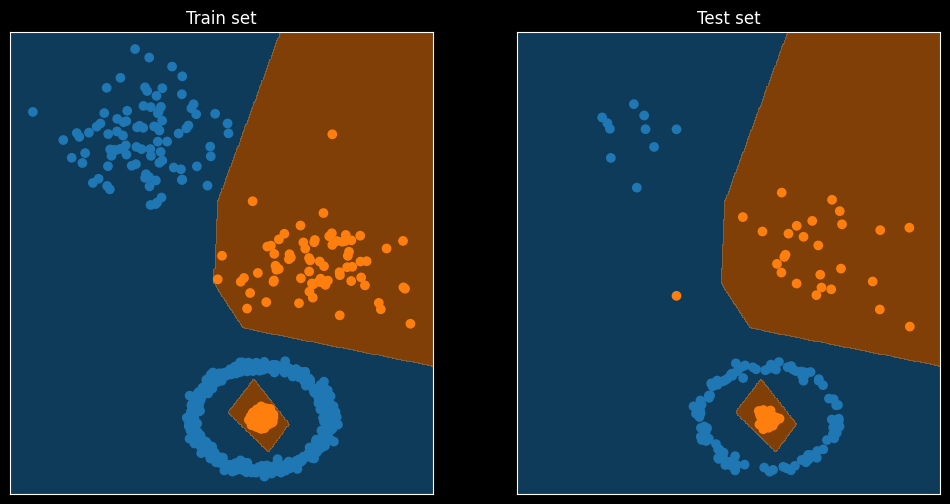

In [ ]:
plot_mesh_predictions, contour_x, contour_y = plot_mesh_predict(dataset.data, trained_model_state)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Train set')
axs[0].contourf(contour_x, contour_y, plot_mesh_predictions, levels=1, colors=plot_colors_hex[0:2], alpha=0.5)
for sample, label in train_data_loader:
  axs[0].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

axs[1].set_title('Test set')
axs[1].contourf(contour_x, contour_y, plot_mesh_predictions, levels=1, colors=plot_colors_hex[0:2], alpha=0.5)
for sample, label in test_data_loader:
  axs[1].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

for ax in axs:
  ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax.set(xlabel=None, ylabel=None)
plt.show()